In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from statistics import mean
import notebook_functions

In [2]:
def calculate_ellipse_from_mask(binary_mask):
    mask = binary_mask.astype(np.int32)
    y_indices, x_indices = np.indices(mask.shape)
    positive_pixels = mask == 255
    result_x = x_indices[positive_pixels]
    result_y = y_indices[positive_pixels]
    n = len(result_x)

    sx = np.sum(result_x)
    cx = sx / len(result_x)
    sxx = np.sum(np.square(result_x))

    sy = np.sum(result_y)
    cy = sy / len(result_y)
    syy = np.sum(np.square(result_y))

    mult_list = [x * y for x, y in zip(result_x, result_y)]
    sxy = np.sum(mult_list)

    sigma_x2 = (sxx / n) - cx ** 2
    sigma_y2 = (syy / n) - cy ** 2
    sigma_xy = (sxy / n) - (cx * cy)

    cov_matrix = [[sigma_x2, sigma_xy], [sigma_xy, sigma_y2]]
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    direction_a = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
    direction_b = eigenvectors[1] / np.linalg.norm(eigenvectors[1])

    a = int(2 * (math.sqrt(abs(eigenvalues[0]))))  # semi major axis of projected ellipse
    b = int(2 * (math.sqrt(abs(eigenvalues[1]))))  # semi minor axis of projected ellipse

    return [a, b], [int(cx), int(cy)], [direction_a, direction_b] ,[*eigenvectors],


In [3]:
def preprocess_img(image):
    green_channel = image[:, :, 1]  # Green channel is at index 1 (0 for blue, 2 for red)
    preprocessed_image = green_channel

    # Step 2: Reduce image resolution by downsampling
    downsampling_factor = 4
    downsampled_image = cv2.resize(preprocessed_image, None, fx=1/downsampling_factor, fy=1/downsampling_factor, interpolation=cv2.INTER_AREA)

    # Step 3: Apply high-pass filtering using Gaussian blur
    sigma = 1.25
    blurred_image = cv2.GaussianBlur(downsampled_image, (0, 0), sigma)
    high_pass_image = downsampled_image - blurred_image
    return high_pass_image

In [4]:
def draw_filled_ellipse(image, image_ellipse, color = (255, 0, 0)):
    axes, center, direction, _ = image_ellipse
    rotation_angle = int(np.degrees(np.arctan2(direction[0][1], direction[0][0])))
    # axes =
    ellipse_box = ((center[0], center[1]), (axes[0] * 2, axes[1] * 2), rotation_angle)   # ellipse axes, center and angle to be drawn on the img given
    cv2.ellipse(image, ellipse_box, color, -1)

In [5]:
# CALCULATE THE NEXT ANGLE IF NEEDED
def angle_estimation(index_view):
    if oblate_angles[index_view] != -1: return oblate_angles[index_view]   # Return if already calculated in another cycle

    #Spheroid values
    A, B = oblate_spheroid
    b_curr = axe_b_all_views[index_view]
    fruit_rot = 'downwards'

    curr_cos_theta = math.sqrt((pow(b_curr, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2)))

    curr_theta_pos = np.degrees(np.arccos(curr_cos_theta))
    curr_theta_neg = np.degrees(-np.arccos(curr_cos_theta))
    current_view_angles = (curr_theta_pos, curr_theta_neg)

    rotation_per_view = 360 / len(axe_b_all_views) - 5
    correct_theta = lambda ascending_sequence: current_view_angles[0] if ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards') else current_view_angles[1]

    # Second ambiguity
    if 0 <= abs(current_view_angles[0]) <= rotation_per_view or abs(90 - rotation_per_view) <= abs(current_view_angles[0]) >= 0:   # Value calculated is in range or a local extrema
        if index_view < len(image_files) - 1:
            temp_correct_theta_value = correct_theta(get_trend_for_view(index_view, 0))
            oblate_angles[index_view] = temp_correct_theta_value
            next_view_angle = angle_estimation(index_view + 1)
            if next_view_angle in [0.0, 90.0, -90.0] or oblate_angles[index_view - 1] in [0.0, 90.0, -90.0]:
                theta = correct_theta(get_trend_for_view(index_view, 0))
            else:
                theta = choose_smooth_angle(oblate_angles[index_view - 1])
        else:
            theta = correct_theta(get_trend_for_view(index_view, 0))
    else:
        theta = correct_theta(get_trend_for_view(index_view, 0))

    oblate_angles[index_view] = theta
    return theta

In [6]:
def get_trend_for_view(index_view, direction = 0, step = 0):
    b_axes = prev_post_values_b(index_view, axe_b_all_views, step, direction)  # Try first with direction 0, in other recursions does direction 1 - forward
    trend = estimate_b_axe_trend(b_axes)
    if trend is None:
        return get_trend_for_view(index_view, 1, step + 1)
    else:
        return trend


In [7]:
def estimate_b_axe_trend(b_axes):
    mean_seq = mean(b_axes)
    if b_axes[0] < mean_seq < b_axes[-1]:
        return True   # "Ascending"
    elif b_axes[0] > mean_seq > b_axes[-1]:
        return False  # "Descending"
    else:
        return None   # No clear trend

In [8]:
def prev_post_values_b(current_b_index, b_list, steps, direction = 0):
    enlarged_b_list = [*b_list, *b_list]
    enlarged_index = current_b_index + len(b_list) - 1 if current_b_index < (len(b_list) / 2) else current_b_index
    total_steps = 3 + steps

    if direction < 0:
        b_axes = enlarged_b_list[(enlarged_index - total_steps) : enlarged_index]
    elif direction > 0:
        b_axes = enlarged_b_list[enlarged_index : (enlarged_index + total_steps)]
    else:
        b_axes = enlarged_b_list[enlarged_index - 2 : enlarged_index + 2]
    return b_axes

In [9]:
def choose_smooth_angle(calc_angle):
    diff_0 = abs(calc_angle - 0)
    diff_90 = abs(calc_angle - 90)
    diff_minus_90 = abs(calc_angle + 90)

    if diff_0 < diff_90 and diff_0 < diff_minus_90 and diff_0 < 40:  # Lower than 40 degrees of difference
        return 0
    elif diff_90 < diff_0 and diff_90 < diff_minus_90:
        return 90
    else:
        return -90

In [10]:
def calculate_z_coordinates(img, index_view, z_coordinates):
    _, center, _, eigenvectors = projected_ellipses[index_view]

    p11 = eigenvectors[1][0]*np.sin(oblate_angles[index_view])
    p12 = eigenvectors[1][0]*np.sin(oblate_angles[index_view])
    p13 = np.cos(oblate_angles[index_view])

    p1 = [p11, p12, p13]
    p2 = [eigenvectors[0][0], eigenvectors[0][1], 0.0]
    p3 = np.cross(p1, p2)

    pose_matrix = np.array([p1, p2, p3])
    equation_matrix = [[1/(B**2), 0, 0], [0, 1/(A**2), 0], [0, 0, 1/(A**2)]]
    matrix_A = pose_matrix.T * equation_matrix * pose_matrix

    for y_pos in range(img.shape[0]):
        for x_pos in range(img.shape[1]):
            xp = x_pos - center[0]
            yp = y_pos - center[1]
            xpyp = [xp, yp]

            # Calculate C
            matrixA1 = np.delete(matrix_A, 2, 1)
            matrixA1 = np.delete(matrixA1, 2, 0)
            C_0 = np.dot(xpyp, matrixA1)
            c = np.dot(C_0, np.transpose(xpyp)) - 1

            # Calculate B
            matrixA2 = np.delete(matrix_A, 0, 1)
            matrixA2 = np.delete(matrixA2, 0, 1)
            matrixA2 = np.delete(matrixA2, 2, 0)
            matrixA3 = np.delete(matrix_A, 0, 0)
            matrixA3 = np.delete(matrixA3, 0, 0)
            matrixA3 = np.delete(matrixA3, 2, 1)
            b = np.dot(xpyp, matrixA2) + np.dot(matrixA3, np.transpose(xpyp))
            b = b[0]

            # Calculate A
            a = matrix_A[2][2]

            # Calculate Z
            sqrt = b*b-4*a*c
            z = (-b + math.sqrt(sqrt))/(2*a)
            z_coordinates[y_pos][x_pos] = z

In [11]:
def rotationMatrixToEulerAngles(R) :
    sy = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if not singular :
        x = np.arctan2(R[2,1] , R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else :
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0
    # Convert to degrees
    x = np.degrees(x)
    y = np.degrees(y)
    z = np.degrees(z)
    return np.array([x, y, z])


In [12]:
sphere_path = "../data/oranges/obj0001"
oblate_path = "../data/mandarins/obj0001"
prolate_path = "../data/tomato_large/bb_obj0000/"
path = oblate_path
axe_b_all_views = []
axe_a_all_views = []
images = []
projected_ellipses = []
oblate_spheroid = []
angle_images = []
image_files = sorted([file for file in os.listdir(path)])
z_coordinates_views_all = []
oblate_angles = [-1 for element in range(len(image_files))]

In [13]:
for image_name in image_files:
    file_path = os.path.join(path, image_name)
    img = cv2.imread(file_path)
    img = preprocess_img(img)
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    ellipse = calculate_ellipse_from_mask(mask)
    axes_length, _, _, _ = ellipse
    major_axis_length, minor_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length)
    axe_a_all_views.append(major_axis_length)
    images.append(img)
    projected_ellipses.append(ellipse)

In [14]:
# SPHEROID CALCULATION  - OBLATE
A = mean(axe_a_all_views)
B = min(axe_b_all_views)
oblate_spheroid = [A, B]

In [15]:
for index, image_name in enumerate(image_files):
    file_path = os.path.join(path, image_name)
    img = cv2.imread(file_path)
    img_axes = cv2.imread(file_path)
    oblate_angle = angle_estimation(index)

## Pasos a seguir
- Tienes un source img y target img
- Consigues puntos relevantes del source img
- Hacer transofrmación para obtener los pts de los puntos relevantes
- Se guardan solo los puntos que despues de transofrmar tienen una z positiva -> "[ps, pt]"
- Se hace función de error entre puntos S -> Valor en pixel (ps) en img source, valor de pixel (pt) en img target

RELEVANT POINTS SELECTION IN VIEWS


In [16]:
source_img_idx = 5
target_img_idx = 6

In [17]:
processed_imgs = [images[source_img_idx], images[target_img_idx]]

### Get L points of source image

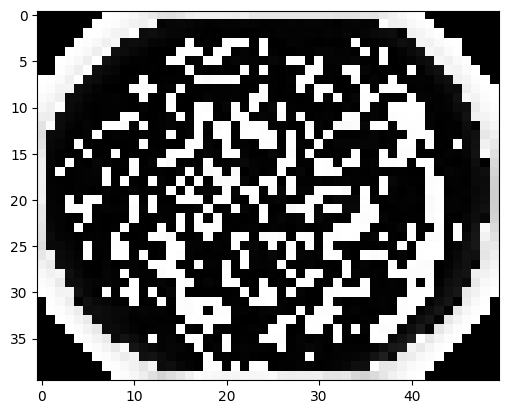

In [18]:
source_ellipse = projected_ellipses[source_img_idx]
current_img = processed_imgs[0]
plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))

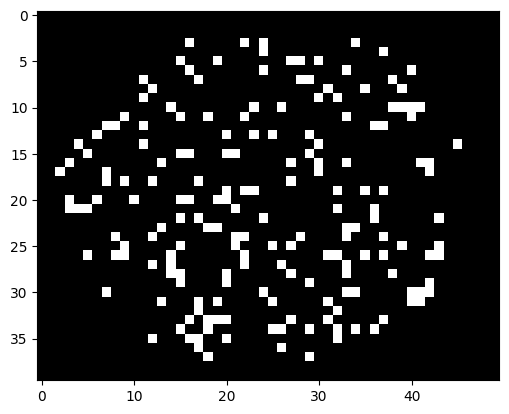

In [19]:
ellipse_mask = np.zeros_like(current_img)
max_exp_rotation_ellipse_axes = [source_ellipse[0][0] / 1.2, source_ellipse[0][1] / 1.2]
max_exp_rotation_ellipse = [max_exp_rotation_ellipse_axes, *source_ellipse[1:]]
draw_filled_ellipse(ellipse_mask, max_exp_rotation_ellipse)
selected_pixels = cv2.bitwise_and(current_img, current_img, mask=ellipse_mask)

percentile_97 = np.percentile(np.abs(selected_pixels), 97)
mask_97 = cv2.inRange(selected_pixels, percentile_97, 255)
final_pixels = cv2.bitwise_and(selected_pixels, selected_pixels, mask=mask_97)
plt.imshow(cv2.cvtColor(final_pixels, cv2.COLOR_BGR2RGB))

## Get S points from source image

In [20]:
z_coordinates = np.zeros_like(processed_imgs[0])  # like source img
s_points = []

### Calculate z values for L points

In [21]:
_, center, _, eigenvectors = projected_ellipses[source_img_idx]
angle_radians = np.radians(oblate_angles[source_img_idx])

p11 = eigenvectors[1][0]*np.sin(angle_radians)
p12 = eigenvectors[1][0]*np.sin(angle_radians)
p13 = np.cos(angle_radians)

p1 = [p11, p12, p13]
p2 = [eigenvectors[0][0], eigenvectors[0][1], 0.0]
p3 = np.cross(p1, p2)

pose_matrix = np.array([p1, p2, p3])
equation_matrix = np.array([[1/(B**2), 0, 0], [0, 1/(A**2), 0], [0, 0, 1/(A**2)]])
matrix_A = pose_matrix.T @ equation_matrix @ pose_matrix

In [22]:
l_points = np.argwhere(final_pixels == 255)
print(len(l_points))

185


In [23]:
for relevant_point in l_points:
    x_pos = relevant_point[1]
    y_pos = relevant_point[0]
    xp = x_pos - center[0]
    yp = y_pos - center[1]
    xpyp = [xp, yp]

    # Calculate C
    matrixA1 = np.delete(matrix_A, 2, 1)
    matrixA1 = np.delete(matrixA1, 2, 0)
    C_0 = np.dot(xpyp, matrixA1)
    c = np.dot(C_0, np.transpose(xpyp)) - 1

    # Calculate B
    matrixA2 = np.delete(matrix_A, 0, 1)
    matrixA2 = np.delete(matrixA2, 0, 1)
    matrixA2 = np.delete(matrixA2, 2, 0)
    matrixA3 = np.delete(matrix_A, 0, 0)
    matrixA3 = np.delete(matrixA3, 0, 0)
    matrixA3 = np.delete(matrixA3, 2, 1)
    b = np.dot(xpyp, matrixA2) + np.dot(matrixA3, np.transpose(xpyp))
    b = b[0]

    # Calculate A
    a = matrix_A[2][2]

    # Calculate Z
    sqrt = b*b-4*a*c
    z = (-b + math.sqrt(sqrt))/(2*a)

    z_coordinates[y_pos][x_pos] = z

Hasta aquí tenemos los valores z para los puntos relevantes L. Hay que separar los valores S usando las coordenadas 3D.

Siguiente paso:
Let pt = (xt′, y′t, zt) be the coordinates in the target view of the transformed point ps , which is obtained using a candidate rotation R

Para conseguir el pt
pt = R * ps


Sacar matriz de rotación y encontrar punto pt

In [24]:
# INITIAL ROTATION MATRIX ESTIMATE
max_expected_rotation = 30
max_degrees = 10
best_rotation_error = []
best_rotation_matrix = []
s_points = []

In [25]:
# rx component 0 - max expected rotation
# ry component - between -x degrees and +degrees

for rotation in range(max_expected_rotation):
    for degrees in range((-10), 10):
        rotation_axis = np.array([rotation, degrees, 0])
        rotation_angle_rad = np.deg2rad(1) # rotation till max expected reached
        rotation_matrix, _ = cv2.Rodrigues(rotation_axis * rotation_angle_rad)

        # Based on the rotation matrix obtain the target points
        for relevant_point in l_points:
            x_pos = relevant_point[1]
            y_pos = relevant_point[0]
            z_pos = z_coordinates[y_pos][x_pos]
            ps = np.array([x_pos, y_pos, z_pos])  # x, y , z positions
            pt = np.dot(rotation_matrix, ps).astype(int)
            if pt[2] > 0.0: s_points.append([ps, pt])  # (x, y ,z)

        # For each rotation calculate error and choose the one with the lowest error
        total_difference = 0
        for point in s_points:
            source_point, target_point = point
            source_pixel = processed_imgs[0][source_point[1], source_point[0]]
            target_pixel = processed_imgs[1][target_point[1], target_point[0]]

            diff = source_pixel - target_pixel
            total_difference += diff

        rotation_error = total_difference / np.abs(len(s_points))

        # STORE ROTATION IF ITS BETTER
        if best_rotation_error > rotation_error or best_rotation_matrix.size() > 0:
            best_rotation_error = rotation_error
            best_rotation_matrix = rotation_matrix

/var/folders/tv/j_hkyyws5nzb4j9vp4gjhj500000gn/T/ipykernel_72159/3322738424.py:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if best_rotation_error > rotation_error or len(best_rotation_matrix) == 0:


In [26]:
rotation_angles = rotationMatrixToEulerAngles(best_rotation_matrix)
print(rotation_angles)

161.01332305459823
[[ 0.99627526  0.02160352  0.08347996]
 [ 0.02160352  0.8746996  -0.48418375]
 [-0.08347996  0.48418375  0.87097485]]
[29.0701262   4.78862212  1.2422234 ]


## TRACK POINTS WITH ROTATION MATRIX
